Journey: Economics PhD Student
====


## 1 Introduction

This notebook is designed as an introduction to someone with the training of a 1st year Economics student, but perhaps without much background in computer programming or scientific computation. As it is a "journey," it is not one big tutorial, but a set of links to notebooks and other resources which will help you understand the different HARK objects and functionalities.

This journey does not require any special skill in programming. However, we recommend you take a few introductory tutorials in Python and object-oriented programming (OOP) to make you familiar with the basic concepts. Moreover, we assume some knowledge in economic theory.

As you have found this journey, you probably have a concept of what a heterogeneous agent model is, but here is a short recap. Think about a basic, infinitely lived consumer problem as you know from first-year graduate courses (letting alone the companies and general equilibrium for now). Using the Bellman equation, we can write it as:

\begin{eqnarray*}
V(M_t) &=& \max_{C_t} U(C_t) + \beta V(M_{t+1}), \\
& s.t. & \\
A_t &=& M_t - C_t, \\
M_{t+1} &=& R (M_{t}-C_{t}) + Y_t, \\
\end{eqnarray*}


Where $\beta <1$ is a discount factor, $C_t$ is consumption, $A_t$ - assets, $Y_t$ - income and $U(C)$ is a standard CRRA utility function:

$$
U(C)=\frac{C^{1-\rho}}{1-\rho}.
$$

Now assume that every consumer faces some uncertainty on her income which is subject to idiosyncratic shocks - the realizations of each shock is (potentially) different for each agent. In this setting, it follows an AR (1) process, so that the current value of $Y$ is a state variable that predicts future values of $Y$.

Then, the Bellman equation looks like:

\begin{eqnarray*}
V(M_t, Y_t) &=& \max_{C_t} U(C_t) + E[\beta V(M_{t+1}, Y_{t+1})], \\
& s.t. & \\
A_t &=& M_t - C_t, \\
M_{t+1} &=& R (M_{t}-C_{t}) + Y_t, \\
\end{eqnarray*}

Finding a distribution of agent assets (consumption, savings) must involve much more advanced numerical tools than in the representative agent setting. This is more demanding task to accomplish and master. Moreover, the knowledge about involved numerical methods is less systematic, and often hard to find. To quote the HARK [Documentation](https://hark.readthedocs.io/en/latest/introduction.html):

*"After months of effort, you may have had the character-improving experience of
proudly explaining to your adviser that not only had you grafted two ideas
together, you also found a trick that speeded the solution by an order of
magnitude, only to be told that your breathtaking insight had been understood
for many years, as reflected in an appendix to a 2008 paper; or, worse, your
discovery was something that “everybody knows” but did not exist at all in
published form!"*

HARK was designed to help you avoid similar experiences. We see two main uses of this package and its tools:

- To simulate the standard heterogeneous agent models without learning all the numerical methods
- To solve your own models building-on the already implemented algorithms

This journey will help you mostly with using HARK in the first way. We do not elaborate here the numerical methods; however, in the last sections you can find some guidance on which methods were used and how the source code is structured.

Although using the prepared package is easier than writing your own solution (what you will need to do sooner or later if you create an original heterogeneous agent model), there is much effort in comprehending the main classes and functionalities of HARK. We hope that this journey will make it easier! We believe that it also  will be your first step into the world of the heterogeneous agents modeling.

---
NOTE
***
We will be very happy to see your feedback. If you have any questions regarding this tutorial or HARK as a whole please see our [Github page](https://github.com/econ-ark/HARK).

---

## 2 Before you start

As we have mentioned before, this journey does not require any special skill in programming. However, some knowledge about Python and object-oriented programing (OOP) is needed. We propose two possible ways to gather the basic concepts; however, plenty of others resources are available:

- Quick introduction to Python and OOP: chapters five to seven from [Quantecon](https://python-programming.quantecon.org/intro.html) should familiarize you with everything what you need for the first tutorials.
- A little longer introduction (if you want to learn something about used numerical methods):
    - Start with the basic Python [tutorial](https://docs.python.org/3/tutorial)
    - Get some knowledge about [Numpy](https://docs.scipy.org/doc/numpy/user/quickstart.html)
- You can also learn Python by learning Machine learning, as there are many tutorials constructed in that way (one example is [scikit-learn tutorials](https://scikit-learn.org/stable/tutorial/index.html)).

## 3 Few words about HARK structure

HARK was written using OOP (we hope that you skimmed the tutorials and have some understanding of this). This means that different parts of the model, like different types of consumers, firms, and general equilibrium conditions (if you have these components in the model), are implemented as different *objects*. Such structure enables you to build your own models with different consumer-type distributions / company structure (if you want some). Importantly, learning the package with such structure implies learning the different types of objects (classes).

In HARK there are two main classes: `AgentType` (think consumers, microeconomic models) and `Market` (think general equilibrium, macroeconomic models). As AgentType objects are the attributes of the Market, we first present this type (additionally, if you are interested only in microeconomic research, you may not want to study the Market class).

In practice, it will take more than two classes to accommodate the variety of models constructed using the toolkit. Thus, each class will have subclasses and those their own subclasses. In general, a more sophisticated class will be defined as a subclass. This journey will reflect this structure, first by presenting the most primitive models, and then the more fancy ones.

---
NOTE
***
In OOP, objects are organized in **classes** (the general structure of the objects) and more specific **subclasses**. The subclass inherits the methods and attributes from the its parent class. Thus, everything which you can do with the object from a general class can be done with the object from its subclass. In case of the economic models, the basic one are always the parent classes of the more sophisticated ones.

---


## 4 Agent-type class
Agent-type class enables you to build microeconomic models (such as the one presented in the introduction). It is also the essential part of the macroeconomic model in HARK. So remember: *to use HARK, you always need to use agent-type classes!*

### 4.1 Introductory example
As an example, let's solve the stochastic model from the introduction. Assume the income process of the agent $i$ in the period t, $Y_{i,t}$, is given by:

\begin{eqnarray*}
Y_{i,t}  &=& \varepsilon_t(\theta_{i,t} p_{i,t}) \\
p_{i,t+1} &=& p_{i,t}\psi_{i,t+1}\\
\psi_{i,t} & \sim & N(1,\sigma_{\varrho})\\
\theta_{i,t} & \sim & N(1,\sigma_{\theta})\\
\end{eqnarray*}

To get a universal solution of this problem, we need to find a policy function (in this case consumption function). This can be done easily using the HARK `solve` function.

Before doing this, we need to declare our model (we assume standard parametrization: R= 1.03, $\rho = 2$, $\beta = 0.96$, $P(\varepsilon=0)= 0.005$, $P(\varepsilon=1)= 0.995$, $\sigma_{\psi}= \sigma_{\theta}=0.1)$:

[comment]: <> (Is this the correct description of the income process? The confusion comes from not knowing the names of a few parameters "epsilon", "P v.s. p"? Does this match the income process defined in the cstw paper?)


In [1]:
import sys  # set path of the notebook
import os

sys.path.insert(0, os.path.abspath("../../."))
from HARK.ConsumptionSaving.ConsIndShockModel import *  # import the module for the idiosyncratic shocks

# we previously defined the paramters to not bother you about it now
import JourneyPhDparam as Params  # imported paramters
from HARK.utilities import plot_funcs  # useful function

Example = IndShockConsumerType()

Next we can solve the model and plot the consumption function:

Consumption function


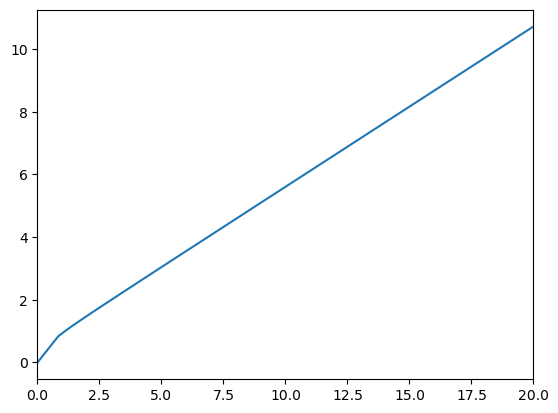

In [2]:
Example.solve()
min_v = Example.solution[
    0
].mNrmMin  # minimal value for which the consumption function is defined
max_v = 20
print("Consumption function")
plot_funcs([Example.solution[0].cFunc], min_v, max_v)

### 4.2 The Agent-Type structure
To understand the microeconomic models in HARK, you need to have some concept of the Agent-type class structure. As it was mentioned, in HARK more advanced models are subclasses of the more primitive ones. The following diagram illustrates this structure: the deterministic class `PerfForesightConsumerType` is the parent for the class of the consumers with idiosyncratic income shocks `IndShockConsumerType`. Subsequently, there is a class defined with both idiosyncratic and aggregate income shocks `𝙼𝚊𝚛𝚔𝚘𝚟ConsumerType`.

![HARK structure](HARK-struct-2.png)

However, it doesn't end there! There are subclasses of the `AggShockConsumerType` which are designed to be integrated with macroeconomic models (we will discuss them in the section devoted to the Market class), as well as there are many other subclasses (which we will mention in the supplementary section).

### 4.3 Main tutorials

To reflect the agent-type structure, we propose you start with the Quickstart notebook (it is devoted to the deterministic case). Then proceed to the idiosyncratic consumers and then to consumers with aggregate and idiosyncratic shocks. The exact order of the suggested tutorials is given in the table.


|Number | Tutorial | Description|
| :---- |  :---- |  :---- |
|1 |[Quickstart](https://github.com/econ-ark/HARK/blob/master/examples/Journeys/Quickstart_tutorial/Quick_start_with_solution.ipynb) |This tutorial familiarize you with the basic HARK objects and functionalities.<br /> You will learn how to create, solve, plot and simulate the deterministic<br /> microeconomic models ($\texttt{PerfForesightConsumerType}$ class).|
|2 |[Idiosyncratic consumers](https://github.com/econ-ark/HARK/blob/master/examples/ConsIndShockModel/IndShockConsumerType.ipynb) |In this tutorial you will learn how to deal<br /> with the microeconomic models with agents with idiosyncratic shocks:<br /> individual productivity shocks ($\texttt{IndShockConsumerType}$ class).  It builds on the Quickstart. |
|3|[Nondurables during great recession](https://github.com/econ-ark/DemARK/blob/master/notebooks/Nondurables-During-Great-Recession.ipynb)| Use you knowledge about HARK to conduct a few economic experiments!<br /> You will examine the effects of the uncertinity increase on the heterogenous<br /> agents with idiosyncratic income risk.|
|4|[Chinese-Growth](https://github.com/econ-ark/DemARK/blob/master/notebooks/Chinese-Growth.ipynb)|Learn how to dealt with models with idiosyncratic <br /> and aggregate risk ($\texttt{𝙼𝚊𝚛𝚔𝚘𝚟ConsumerType}$ class). <br />Next build advanced simulation with many agent types.|


### 4.4 Supplementary tutorials

The aforementioned four tutorials are the most essential ones. However, in HARK there are a few other classes with a similar structure as three basic ones (with some minor differences). Here is a list of the notebooks which familiarize you with them (if you so wish, as it is not required to understand the next topics).

|Number | Tutorial | Description|
| :---- |  :---- |  :---- |
|1* |[Kinked consumer](https://github.com/econ-ark/HARK/blob/master/examples/ConsIndShockModel/KinkedRconsumerType.ipynb) | $\texttt{KinkedRconsumerType}$ is a subclass of $\texttt{IndShockConsumerType}$. <br /> In enables to set different borrowing and lending interest rate. |
|2* |[Buffer-stock consumer](https://github.com/econ-ark/DemARK/blob/master/notebooks/Gentle-Intro-To-HARK-Buffer-Stock-Model.ipynb) | In the Buffer Stock model, the unemployment state (zero income stat) is irreversible.<br /> This framework is implemented by $\texttt{TractableConsumerType}$ class.<br /> For the analytical properties of buffer stock model check this [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock/).|
|3*|[Generalized income process](https://github.com/econ-ark/HARK/blob/master/examples/GenIncProcessModel/GenIncProcessModel.ipynb)| In $\texttt{IndShockConsumerType}$ class, the idiosyncratic income shocks<br /> were assumed to be or purely permanent or purely transitory. In the similar class <br /> $\texttt{PersistentShockConsumerType}$ the income shocks follows AR(1) process with parameter <1,<br /> thus there are not full permanent nor transitory <br />(it was called generalized income process).|



## 5 Market class

In macroeconomic models, the consumers are only one possible type of agent. In such models, the economy contains also firms and a government (or other types of agents). In HARK, several standard macro models were implemented using the **Market** class and its subclasses.



### 5.1 Introductory example

Let's extend our model from the previous section. Assume the perfect competition and Cobb-Douglas production function:

\begin{eqnarray*}
y_t = k_t^{\alpha} n_t^{1-\alpha}
\end{eqnarray*}
Thus, the producers' problem is:
\begin{eqnarray*}
\max_{k_t, n_t} &\: k_t^{\alpha} n_t^{1-\alpha} - (R_t +\delta)k_t-w_t n_t
\end{eqnarray*}

Where $k_t$ is capital, $n_t$ is labour, $\delta$ is a depreciation rate.

In this case, consumers' incomes are determined by the wage:

[comment]: <> (Should there be an equation here? Or is this information apparent from the bellman equation?)

\begin{eqnarray*}
V(M_{i,t}, Y_{i,t}) &=& \max_{C_{i,t}, M_{i,t+1}} U(C_{i,t}) + E[\beta V(M_{i,t+1}, Y_{i,t+1})], \\
& s.t. & \\
A_{i,t} &=& M_{i,t} - C_{i,t}, \\
M_{i,t+1} &=& R_{t+1} (M_{i,t}-C_{i,t}) + w_{t+1} Y_{i,t+1}, \\
\end{eqnarray*}

Additionally, assume that the distribution of the consumers over capital is given by the measure $\Gamma_t$. To close the economy, there are the market clearing conditions:
\begin{eqnarray*}
n_t &= \int Y{_i,t} d \Gamma_t \\
k_{t+1} &= \int A_{i,t}^i d \Gamma_t \\
k_{t+1}+ \int C_{i,t} d\Gamma_t &= y_t+(1-\delta)k_t
\end{eqnarray*}

In HARK, you can solve this basic case by using the `CobbDouglasEconomy` class. However, to add the consumers to the economy you need the `AggShockConsumerType` class, which is a subclass of `IndShockConsumerType` Let's declare the economy (assuming depreciation rate $\delta = 0.025$):


In [3]:
from HARK.ConsumptionSaving.ConsAggShockModel import *  # module with the economy classes

AggShockExample = AggShockConsumerType(
    **Params.init_agg_shocks
)  # declare the consumer, using the previously prepared parameters

# Make a Cobb-Douglas economy for the agents
EconomyExample = CobbDouglasEconomy(
    agents=[AggShockExample], **Params.init_cobb_douglas
)

Now, you can solve the economy and plot the aggregate savings function:

capital-level steady state:  13.943289665216982


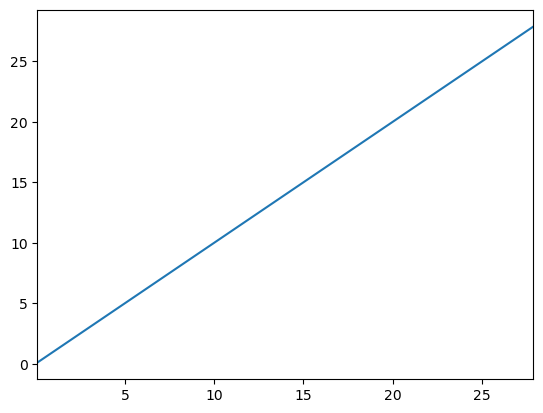

In [4]:
EconomyExample.make_AggShkHist()  # Simulate a history of aggregate shocks

# Have the consumers inherit relevant objects from the economy
AggShockExample.get_economy_data(EconomyExample)

AggShockExample.solve()  # solve the model

print(
    "capital-level steady state: ", EconomyExample.kSS
)  # print the capital-level steady stae

plot_funcs(
    AggShockExample.AFunc, 0.1, 2 * EconomyExample.kSS
)  # plot the aggregate savings function

### 5.2 Market class structure

As in the case of the agent-type, the more complicated macroeconomic models are the subclasses of more primitive ones. The subclasses of Market include `CobbDouglasEconomy` and `SmallOpenEconomy`. The main difference between them is that for `CobbDouglasEconomy`, the capital and labour prices are endogenous, while in the (small) open economy class both are set exogenously.

Nevertheless, both basic classes enable the aggregate fluctuation in the economy, that is:

\begin{eqnarray*}
Y_{i,t}  &=& \varepsilon_t(\epsilon_{i,t}p_{i,t}\Theta_t P_t )\\
P_{t+1} &=& P_{t}\Psi_{t+1}\\
\Psi_{t}  &\sim & {N}(1,\sigma_{\Psi})\\
\Theta_t  &\sim &{N}(1,\sigma_{\Theta})\\
\end{eqnarray*}

The consumers, which are attributes of such market classes, need to include the aggregate fluctuations of the whole economy in their optimization problem. This is the reason why the `AggShockConsumerType` class (and their subclasses) must be used to construct the macro-model.

The subclass of `CobbDouglasEconomy` is `CobbDouglasMarkovEconomy`. In this setting, there exists an additional aggregate fluctuation in the economy (the distribution of which is given by the finite Markov matrix).


![HARK_struct_2](HARK-struct-4.png)




### 5.3 Tutorial

To learn the functionalities of the market-type classes in HARK we suggest studying the following notebook devoted to [Krussel-Smith economy](https://github.com/econ-ark/REMARK/blob/master/REMARKs/KrusellSmith.md). In this notebook, the classical [Krussell-Smith model](https://www.journals.uchicago.edu/doi/abs/10.1086/250034?journalCode=jpe) is implemented (with some extensions) using the `CobbDouglasMarkovEconomy` class.

Before that, you may want to check the main function from [ConsAggShockModel module](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsAggShockModel.ipynb) or its [source code](https://github.com/econ-ark/HARK/blob/master//HARK/ConsumptionSaving/ConsAggShockModel.py) to see the basic steps to create the market type objects.



#### 5.3.1 If you want to learn (a little) how the Market class works

The Market class was designed to be a general framework for many different macro models. It involves a procedure of aggregating the agents' choices: eg. aggregating consumption and savings (`reap_vars` in the code) and then transforming the aggregated variables (`mill_rule` in the code).

If you would like to get better knowledge about this structure, first take a look at the [Hark documentation](https://hark.readthedocs.io/en/latest/ARKitecture.html). Next, to understand how the HARK Market class works in less standard setting, look at the [Fashion victim model](../notebooks/Fashion-Victim-Model.ipynb).


## 6 If you need to study a source code

In the previous sections we saw an example of how to solve different models using HARK. However, we know that you may also need to work with the source code for a few reasons (e.g. to learn used numerical methods, write your own code).

Working directly with code (even if well-written) is a much more complicated tasks than just working with finished functions, and no tutorial will let you go through this painlessly. However, we hope that this partelaborating on the HARK structure and numerical methods will help you with this task.

### 6.1 A few more words on HARK structure

When you look at the [HARK](https://github.com/econ-ark/HARK) sources, you will find the subdirectory called HARK. Next there is a script called "core. py". Surprisingly, you will not find this code in many of the subclasses which you learned during this journey!

The reason for this is that HARK.core.py is a core of the package: a framework  for all models which can be coded in HARK. It contains the general framework of the agent-type classes (AgentType class) and for the market. The exact structure of modules in the HARK core you can find in the [Hark documentation](https://hark.readthedocs.io/en/latest/ARKitecture.html#general-purpose-tools). Here, you can also find the general structure of the [AgentType](https://hark.readthedocs.io/en/latest/ARKitecture.html#agenttype-class) and [Market classes](https://hark.readthedocs.io/en/latest/ARKitecture.html#market-class).

Where are the subclasses which you'v learned during the journey? In HARK, the subclasses are located in the separate directories. For the AgentType subclasses, you need to look at HARK.ConsumptionSaving directory. For example, `PerfForesightConsumerType` and `IndShockConsumerType` can be found in ConsIndShockModel.py. Nevertheless, if you want to understand any of the HARK modules, you must first understand `HARK.core`.


### 6.2 HARK solution

For the consumer problems, solutions of the one-period consumer's problem are found using the attribute function `solve_one_period`. The inputs passed to this function also include data from the subsequent periods. Before solve_one_period is called, the function pre_solve() is applied, which prepare the solution (eg. transmit the solution of the sub-sequent period as an input).

The structure of the functions which are used as solve_one_period reflects the agent-type class structures. Thus, when you will study the source code, you will first read the solve classes.

![Hark_struct3](HARK-struct-3.png)


#### 6.2.1 Solution method for agent problem
However, knowing the structure of the code may not be very beneficial if you do not know the solution method! While for the perfect foresight consumer has an analytic solution, the policy functions for the stochastic consumer (thus with the idiosyncratic or the aggregate shocks) are solved by the **endogenous grid method**.

The method of endogenous gridpoints is now widely used in macroeconomic simulations. There are a few resources to learn it; here, we suggest Professor Carroll's [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/SolvingMicroDSOPs/). If you prefer a very quick version, we suggest appendix to the Kruger and Kindermann [paper](https://www.nber.org/papers/w20601.pdf) (they develop a slightly bigger model with a different notation, but the idea is the same).

#### 6.2.2 Finding general equilibrium
In general, the rational expectations general equilibrium is found by updating the agents' expectations and the aggregate choices up to the point at which the actual aggregated variables (like interest rate or capital) are equal to the expected ones. However, one may need to refer to the papers cited in the notebooks to understand the exact methods used.


### 6.3 How to study HARK codes

We hope that this section gave you some idea how the HARK library works. However, HARK contains much more than is discussed here. Here is some more guidance on how to continue your journey:

- Before you start make sure that you understand the endogenous grid method, as well as the general framework structure for AgentType and Market from [HARK documentation](https://hark.readthedocs.io/en/latest/ARKitecture.html#agenttype-class).
- When working through HARK.core, make sure that you see the connection between the structure in the documentation and the code (check autodoc from the [HARK documentation](https://hark.readthedocs.io/en/latest/reference/tools/core.html) webpage).
- Proceed to the ConsumptionSaving/ConsIndShockModel.py and compare the tutorials with the source code.
- Proceed to the ConsumptionSaving/ConsAggShockModel.py and compare the tutorial on the Market class with the source code, check [autodoc](https://hark.readthedocs.io/en/latest/reference/ConsumptionSaving/ConsAggShockModel.html).

So in general, when you want to learn any of the modules in the HARK toolkit, first check autodoc from the [HARK documentation](https://hark.readthedocs.io/en/latest/reference/index.html) webpage.
